# Part 3: Validation

In [1]:
%%capture
%pip install python-terrier

import pyterrier as pt
from pyterrier.measures import *
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm


from my_utils import query_similar_words
from my_utils import preprocess

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.11.0-openjdk-amd64/"

if not pt.started():
  pt.init()

PyTerrier 0.7.2 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)


No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [3]:
def create_index(docs_df, mode="both", indexer_path="./pd_index"):

    pd_indexer = pt.DFIndexer(indexer_path, remove_stopwords=False, overwrite=True)
    pd_indexer.setProperty("termpipelines", "")
    #pd_indexer.setProperty("metaindex.compressed.reverse.allow.duplicates", "False")

    if mode == "title":
        index_ref = pd_indexer.index(docs_df["title"], docs_df["docno"])
    elif mode == "abstract":
        index_ref = pd_indexer.index(docs_df["abstract"], docs_df["docno"])
    else:  # both or else
        index_ref = pd_indexer.index(docs_df["title"], docs_df["abstract"], docs_df["docno"])

    return index_ref

def index_model(index, model="TF_IDF"):
    """
    Create and return an indexing model.
    http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html
    Model can be such as:
    "TF_IDF", "PL2", "DLH",
    "Hiemstra_LM", "Dirichlet_LM",
    "BM25", etc
    """
    list_model = ["TF_IDF", "PL2", "DLH", "Hiemstra_LM", "Dirichlet_LM", "BM25"]

    indexing_model = pt.BatchRetrieve(index, wmodel=model)
    return indexing_model

def preprocess_queries(queries, augemented=False, mv_model=None):
    queries_preprocessed = queries.copy()
    for index, row in tqdm(queries.iterrows(), total=len(queries)):
        pre_processed_title = " ".join(preprocess(row["title"]))
        pre_processed_description = " ".join(preprocess(row["description"]))
        pre_processed_narrative = " ".join(preprocess(row["narrative"]))

        if augemented:
            pre_processed_title = query_similar_words(pre_processed_title, mv_model)
            pre_processed_description = query_similar_words(pre_processed_description, mv_model)
            pre_processed_narrative = query_similar_words(pre_processed_narrative, mv_model)

        queries_preprocessed.loc[index, "title"] = pre_processed_title
        queries_preprocessed.loc[index, "description"] = pre_processed_description
        queries_preprocessed.loc[index, "narrative"] = pre_processed_narrative

    if augemented:
        queries_preprocessed.to_pickle("data/queries_processed_aug.pkl")
    else:
        queries_preprocessed.to_pickle("data/queries_processed.pkl")

    return queries_preprocessed

def expirement(indexed_docs, preprocessed_query, qrels):
    tfidf = index_model(indexed_docs, model="TF_IDF")
    bm25 = index_model(indexed_docs, model="BM25")
    dirichlet_lm = index_model(indexed_docs, model="DirichletLM")

    exp = pt.Experiment(
        [tfidf, bm25, dirichlet_lm],
        preprocessed_query,
        qrels,
        eval_metrics=[P@5, P@10, nDCG@10, RR(rel=2)],
        names=["TF_IDF", "BM25", "DirichletLM"]
    )
    return exp

## Experiments
 - preprocessing: {all languages, only english}
 - topics: {title, description, narrative}
 - indexing: {title, abstract, both}
 - models: {tf_idf, bm25, dirichlet_lm}

In [ ]:
%%capture

# read preprocessed en-documents
en_docs = pd.read_pickle('./data/en_docs_processed.pkl')
en_docs.rename(columns={"doc_id":"docno"}, inplace=True)

# index en-documents by (title, abstract, both)
index_ref_en_docs_title = create_index(en_docs, mode="title", indexer_path="./indexes/en/title")
index_en_docs_title = pt.IndexFactory.of(index_ref_en_docs_title)

index_ref_en_docs_abstract = create_index(en_docs, mode="abstract", indexer_path="./indexes/en/abstract")
index_en_docs_abstract = pt.IndexFactory.of(index_ref_en_docs_abstract)

index_ref_en_docs_both = create_index(en_docs, mode="both", indexer_path="./indexes/en/both")
index_en_docs_both = pt.IndexFactory.of(index_ref_en_docs_both)

In [ ]:
%%capture
# read preprocessed documents
docs = pd.read_pickle('./data/docs_processed.pkl')
docs.rename(columns={"doc_id":"docno"}, inplace=True)

# index documents by (title, abstract, both)
index_ref_docs_title = create_index(docs, mode="title", indexer_path="./indexes/all/title")
index_docs_title = pt.IndexFactory.of(index_ref_docs_title)

index_ref_docs_abstract = create_index(docs, mode="abstract", indexer_path="./indexes/all/abstract")
index_docs_abstract = pt.IndexFactory.of(index_ref_docs_abstract)


index_ref_docs_both = create_index(docs, mode="both", indexer_path="./indexes/all/both")
index_docs_both = pt.IndexFactory.of(index_ref_docs_title)

In [6]:
# preprocess queries by (title, description, narrative)
import ir_datasets
dataset = ir_datasets.load("cord19/trec-covid")
queries = pd.DataFrame(dataset.queries_iter())
queries = preprocess_queries(queries, augemented=False, mv_model=None)
display(queries.head(5))

pq_title = queries[['query_id', 'title']]
pq_title = pq_title.rename(columns={'query_id':'qid', 'title':'query'})
display(pq_title.head(5))

pq_desc = queries[['query_id', 'description']]
pq_desc = pq_desc.rename(columns={'query_id':'qid', 'description':'query'})
display(pq_desc.head(5))

pq_narr = queries[['query_id', 'narrative']]
pq_narr = pq_narr.rename(columns={'query_id':'qid', 'narrative':'query'})
display(pq_narr.head(5))

  0%|          | 0/50 [00:00<?, ?it/s]

,query_id,title,description,narrative
0,1,coronavirus origin,origin covid19,seek range information sarscov2 virus origin i...
1,2,coronavirus response weather change,coronavirus respond change weather,seek range information sarscov2 virus viabilit...
2,3,coronavirus immunity,sarscov2 infect people develop immunity cross ...,seek study immunity develop due infection sars...
3,4,people die coronavirus,cause death covid19,study look mechanism death covid19
4,5,animal model covid19,drug active sarscov sarscov2 animal study,paper describe result test drug bind spike pro...


,qid,query
0,1,coronavirus origin
1,2,coronavirus response weather change
2,3,coronavirus immunity
3,4,people die coronavirus
4,5,animal model covid19


,qid,query
0,1,origin covid19
1,2,coronavirus respond change weather
2,3,sarscov2 infect people develop immunity cross ...
3,4,cause death covid19
4,5,drug active sarscov sarscov2 animal study


,qid,query
0,1,seek range information sarscov2 virus origin i...
1,2,seek range information sarscov2 virus viabilit...
2,3,seek study immunity develop due infection sars...
3,4,study look mechanism death covid19
4,5,paper describe result test drug bind spike pro...


In [7]:
# load trec-covid dataset
cord19 = pt.get_dataset("irds:cord19/trec-covid")
qrels = cord19.get_qrels()

In [8]:
# en_docs {title, abstract, both} with query_title
exp1 = expirement(index_en_docs_title, pq_title, qrels)
display(exp1)

exp2 = expirement(index_en_docs_abstract, pq_title, qrels)
display(exp2)

exp3 = expirement(index_en_docs_both, pq_title, qrels)
display(exp3)

# en_docs {title, abstract, both} with query_description
exp4 = expirement(index_en_docs_title, pq_desc, qrels)
display(exp4)

exp5 = expirement(index_en_docs_abstract, pq_desc, qrels)
display(exp5)

exp6 = expirement(index_en_docs_both, pq_desc, qrels)
display(exp6)

# en_docs {title, abstract, both} with query_narrative
exp7 = expirement(index_en_docs_title, pq_narr, qrels)
display(exp7)

exp8 = expirement(index_en_docs_abstract, pq_narr, qrels)
display(exp8)

exp9 = expirement(index_en_docs_both, pq_narr, qrels)
display(exp9)

,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.568,0.560,0.519932,0.622459
1,BM25,0.576,0.546,0.509432,0.613922
2,DirichletLM,0.540,0.508,0.468562,0.551351


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.728,0.688,0.632865,0.724063
1,BM25,0.664,0.646,0.588473,0.700447
2,DirichletLM,0.672,0.670,0.594023,0.591624


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.620,0.584,0.550996,0.657000
1,BM25,0.624,0.576,0.542067,0.648562
2,DirichletLM,0.560,0.540,0.495038,0.599225


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.632,0.546,0.535308,0.671064
1,BM25,0.640,0.548,0.521520,0.611938
2,DirichletLM,0.440,0.428,0.396092,0.488072


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.736,0.702,0.645485,0.784202
1,BM25,0.676,0.640,0.566200,0.633944
2,DirichletLM,0.696,0.660,0.606684,0.665928


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.652,0.578,0.556238,0.674510
1,BM25,0.656,0.566,0.546837,0.673774
2,DirichletLM,0.496,0.458,0.417565,0.511969


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.468,0.418,0.383628,0.496482
1,BM25,0.448,0.432,0.386476,0.477315
2,DirichletLM,0.252,0.226,0.213848,0.337682


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.584,0.574,0.519027,0.602736
1,BM25,0.548,0.548,0.493708,0.614159
2,DirichletLM,0.440,0.436,0.391514,0.525963


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.468,0.428,0.399881,0.538915
1,BM25,0.468,0.434,0.403713,0.535349
2,DirichletLM,0.248,0.210,0.203448,0.322527


In [9]:
# docs {title, abstract, both} with query_title
exp1 = expirement(index_docs_title, pq_title, qrels)
display(exp1)

exp2 = expirement(index_docs_abstract, pq_title, qrels)
display(exp2)

exp3 = expirement(index_docs_both, pq_title, qrels)
display(exp3)

# docs {title, abstract, both} with query_description
exp4 = expirement(index_docs_title, pq_desc, qrels)
display(exp4)

exp5 = expirement(index_docs_abstract, pq_desc, qrels)
display(exp5)

exp6 = expirement(index_docs_both, pq_desc, qrels)
display(exp6)

# docs {title, abstract, both} with query_narrative
exp7 = expirement(index_docs_title, pq_narr, qrels)
display(exp7)

exp8 = expirement(index_docs_abstract, pq_narr, qrels)
display(exp8)

exp9 = expirement(index_docs_both, pq_narr, qrels)
display(exp9)

,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.568,0.560,0.519932,0.622459
1,BM25,0.576,0.546,0.509432,0.613922
2,DirichletLM,0.540,0.508,0.468562,0.551351


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.728,0.688,0.632865,0.724063
1,BM25,0.664,0.646,0.588473,0.700447
2,DirichletLM,0.672,0.670,0.594023,0.591624


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.568,0.560,0.519932,0.622459
1,BM25,0.576,0.546,0.509432,0.613922
2,DirichletLM,0.540,0.508,0.468562,0.551351


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.632,0.546,0.535308,0.671064
1,BM25,0.640,0.548,0.521520,0.611938
2,DirichletLM,0.440,0.428,0.396092,0.488072


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.736,0.702,0.645485,0.784202
1,BM25,0.676,0.640,0.566200,0.633944
2,DirichletLM,0.696,0.660,0.606684,0.665928


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.632,0.546,0.535308,0.671064
1,BM25,0.640,0.548,0.521520,0.611938
2,DirichletLM,0.440,0.428,0.396092,0.488072


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.468,0.418,0.383628,0.496482
1,BM25,0.448,0.432,0.386476,0.477315
2,DirichletLM,0.252,0.226,0.213848,0.337682


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.584,0.574,0.519027,0.602736
1,BM25,0.548,0.548,0.493708,0.614159
2,DirichletLM,0.440,0.436,0.391514,0.525963


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.468,0.418,0.383628,0.496482
1,BM25,0.448,0.432,0.386476,0.477315
2,DirichletLM,0.252,0.226,0.213848,0.337682


## Query Expansion

In [10]:
AUGMENTED = True
if AUGMENTED:
    from gensim.models import Word2Vec
    mv_model = Word2Vec.load("data/word2vec.model")

dataset = ir_datasets.load("cord19/trec-covid")
queries = pd.DataFrame(dataset.queries_iter())
queries = preprocess_queries(queries, augemented=True, mv_model=mv_model)
display(queries.head(5))

pq_title = queries[['query_id', 'title']]
pq_title = pq_title.rename(columns={'query_id':'qid', 'title':'query'})
display(pq_title.head(5))

pq_desc = queries[['query_id', 'description']]
pq_desc = pq_desc.rename(columns={'query_id':'qid', 'description':'query'})
display(pq_desc.head(5))

pq_narr = queries[['query_id', 'narrative']]
pq_narr = pq_narr.rename(columns={'query_id':'qid', 'narrative':'query'})
display(pq_narr.head(5))

  0%|          | 0/50 [00:00<?, ?it/s]

,query_id,title,description,narrative
0,1,coronavirus coronavirussevere origin pangolins,origin pangolins covid19 disease,seek paths range interquartile information dat...
1,2,coronavirus coronavirussevere response respons...,coronavirus coronavirussevere respond ghdemphn...,seek paths range interquartile information dat...
2,3,coronavirus coronavirussevere immunity vaccine...,sarscov2 viral infect infected people individu...,seek paths study pacovid19 immunity vaccineind...
3,4,people individual die died coronavirus coronav...,cause responsible death deaths covid19 disease,study pacovid19 look ive mechanism mechanisms ...
4,5,animal humans model susceptibleexposedinfected...,drug repurposing active phytocompounds sarscov...,paper addressing describe present result asses...


,qid,query
0,1,coronavirus coronavirussevere origin pangolins
1,2,coronavirus coronavirussevere response respons...
2,3,coronavirus coronavirussevere immunity vaccine...
3,4,people individual die died coronavirus coronav...
4,5,animal humans model susceptibleexposedinfected...


,qid,query
0,1,origin pangolins covid19 disease
1,2,coronavirus coronavirussevere respond ghdemphn...
2,3,sarscov2 viral infect infected people individu...
3,4,cause responsible death deaths covid19 disease
4,5,drug repurposing active phytocompounds sarscov...


,qid,query
0,1,seek paths range interquartile information dat...
1,2,seek paths range interquartile information dat...
2,3,seek paths study pacovid19 immunity vaccineind...
3,4,study pacovid19 look ive mechanism mechanisms ...
4,5,paper addressing describe present result asses...


In [11]:
# en_docs {title, abstract, both} with query_title
exp1 = expirement(index_en_docs_title, pq_title, qrels)
display(exp1)

exp2 = expirement(index_en_docs_abstract, pq_title, qrels)
display(exp2)

exp3 = expirement(index_en_docs_both, pq_title, qrels)
display(exp3)

# en_docs {title, abstract, both} with query_description
exp4 = expirement(index_en_docs_title, pq_desc, qrels)
display(exp4)

exp5 = expirement(index_en_docs_abstract, pq_desc, qrels)
display(exp5)

exp6 = expirement(index_en_docs_both, pq_desc, qrels)
display(exp6)

# en_docs {title, abstract, both} with query_narrative
exp7 = expirement(index_en_docs_title, pq_narr, qrels)
display(exp7)

exp8 = expirement(index_en_docs_abstract, pq_narr, qrels)
display(exp8)

exp9 = expirement(index_en_docs_both, pq_narr, qrels)
display(exp9)

,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.512,0.476,0.431033,0.506843
1,BM25,0.520,0.474,0.431256,0.522737
2,DirichletLM,0.276,0.352,0.272027,0.245014


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.500,0.494,0.446681,0.552153
1,BM25,0.484,0.472,0.435568,0.543153
2,DirichletLM,0.272,0.310,0.290487,0.396614


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.556,0.490,0.446631,0.521205
1,BM25,0.556,0.484,0.444198,0.530412
2,DirichletLM,0.316,0.376,0.294404,0.268150


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.544,0.524,0.472663,0.573377
1,BM25,0.496,0.522,0.466410,0.577236
2,DirichletLM,0.228,0.296,0.243216,0.252844


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.576,0.606,0.536797,0.614397
1,BM25,0.552,0.554,0.499235,0.606875
2,DirichletLM,0.432,0.416,0.391555,0.535627


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.596,0.538,0.489908,0.584238
1,BM25,0.572,0.550,0.494153,0.591458
2,DirichletLM,0.320,0.344,0.287447,0.341385


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.372,0.364,0.338747,0.454576
1,BM25,0.380,0.376,0.347400,0.448903
2,DirichletLM,0.180,0.168,0.157987,0.246711


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.504,0.494,0.441591,0.500479
1,BM25,0.476,0.472,0.430594,0.508504
2,DirichletLM,0.292,0.272,0.259937,0.409548


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.384,0.354,0.332389,0.449136
1,BM25,0.384,0.380,0.344488,0.434279
2,DirichletLM,0.176,0.178,0.169868,0.268648


In [12]:
# docs {title, abstract, both} with query_title
exp1 = expirement(index_docs_title, pq_title, qrels)
display(exp1)

exp2 = expirement(index_docs_abstract, pq_title, qrels)
display(exp2)

exp3 = expirement(index_docs_both, pq_title, qrels)
display(exp3)

# docs {title, abstract, both} with query_description
exp4 = expirement(index_docs_title, pq_desc, qrels)
display(exp4)

exp5 = expirement(index_docs_abstract, pq_desc, qrels)
display(exp5)

exp6 = expirement(index_docs_both, pq_desc, qrels)
display(exp6)

# docs {title, abstract, both} with query_narrative
exp7 = expirement(index_docs_title, pq_narr, qrels)
display(exp7)

exp8 = expirement(index_docs_abstract, pq_narr, qrels)
display(exp8)

exp9 = expirement(index_docs_both, pq_narr, qrels)
display(exp9)

,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.512,0.476,0.431033,0.506843
1,BM25,0.520,0.474,0.431256,0.522737
2,DirichletLM,0.276,0.352,0.272027,0.245014


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.500,0.494,0.446681,0.552153
1,BM25,0.484,0.472,0.435568,0.543153
2,DirichletLM,0.272,0.310,0.290487,0.396614


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.512,0.476,0.431033,0.506843
1,BM25,0.520,0.474,0.431256,0.522737
2,DirichletLM,0.276,0.352,0.272027,0.245014


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.544,0.524,0.472663,0.573377
1,BM25,0.496,0.522,0.466410,0.577236
2,DirichletLM,0.228,0.296,0.243216,0.252844


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.576,0.606,0.536797,0.614397
1,BM25,0.552,0.554,0.499235,0.606875
2,DirichletLM,0.432,0.416,0.391555,0.535627


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.544,0.524,0.472663,0.573377
1,BM25,0.496,0.522,0.466410,0.577236
2,DirichletLM,0.228,0.296,0.243216,0.252844


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.372,0.364,0.338747,0.454576
1,BM25,0.380,0.376,0.347400,0.448903
2,DirichletLM,0.180,0.168,0.157987,0.246711


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.504,0.494,0.441591,0.500479
1,BM25,0.476,0.472,0.430594,0.508504
2,DirichletLM,0.292,0.272,0.259937,0.409548


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.372,0.364,0.338747,0.454576
1,BM25,0.380,0.376,0.347400,0.448903
2,DirichletLM,0.180,0.168,0.157987,0.246711


# Pairwise Similarity of Queries
# - TF-IDF
# - DOC2VEC

Write a function that measures the pairwise similarity of the provided 
queries. Create a list of similar queries and a word-cloud of their qids.

In [13]:
%%capture
%pip install gensim

import pandas as pd
import numpy as np
import wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def compute_freqs(queries, labels):
    freqs = {}
    for i in range(max(labels)):
        # print(f"cluster {i:2} {queries.loc[labels==i]['title'].values}")

        similar_queries = queries.loc[labels==i]['query_id'].values
        for qid in similar_queries:
            freqs[qid] = len(similar_queries)

    return freqs

def print_clustered_queries(queries, labels):
    for i in range(max(labels)):
        print(f"cluster {i:2} {queries.loc[labels==i]['description'].values}")

In [14]:
if AUGMENTED:
    queries = pd.read_pickle('./data/queries_processed_aug.pkl')
else:
    queries = pd.read_pickle('./data/queries_processed.pkl')

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(queries['description']).toarray()

cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=0.9)
labels = cluster.fit_predict(vectors)

print_clustered_queries(queries, labels)

cluster  0 ['coronavirus coronavirussevere respond ghdemphnet change alter weather meteorological'
 'serological serology test testing detect ndv antibody neutralize coronavirus coronavirussevere'
 'transmission humantohuman route fetaloral coronavirus coronavirussevere'
 'long short coronavirus coronavirussevere live retirement outside provinces body contagium'
 'long short coronavirus coronavirussevere remain still stable stability surface contaminate']
cluster  1 ['drug repurposing active phytocompounds sarscov sarscov1 sarscov2 viral animal humans study pacovid19'
 'sarscov2 viral proteinshuman proteins protein interaction interact indicate suggest potential possible drug repurposing target macrocyclic approve approved drug repurposing repurposed repurposing base basis information data'
 'sarscov2 viral subtypes cocirculation'
 'protein proteins structure cryoelectron sarscov2 viral spike glycoprotein']
cluster  2 ['evidence literature relate related covid19 disease super spreader 

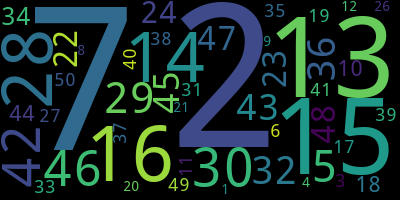

In [15]:
wordcloud.WordCloud().fit_words(compute_freqs(queries, labels)).to_image()

In [16]:
tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(queries['description'])]
doc_model = Doc2Vec(tagged_data, window=5, seed=1)
d2v_doc_embeddings = np.array([doc_model.infer_vector(doc.split()) for doc in queries['description']])
print(d2v_doc_embeddings.shape)

cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=0.95)
labels = cluster.fit_predict(d2v_doc_embeddings)

print_clustered_queries(queries, labels)

(50, 100)
cluster  0 ['type ii rapid prompt test testing covid19 disease develop developed'
 'covid19 disease affect affected canada united'
 'protein proteins structure cryoelectron sarscov2 viral spike glycoprotein'
 'benefit harm risk contracting reopen lift school closure midst inundate covid19 disease pandemic crisis']
cluster  1 ['coronavirus coronavirussevere respond ghdemphnet change alter weather meteorological'
 'sarscov2 viral infect infected people individual develop developed immunity vaccineinduced cross sectional protection protective possible potential'
 'drug repurposing active phytocompounds sarscov sarscov1 sarscov2 viral animal humans study pacovid19'
 'type ii hand hygiene sanitizer alcoholbased need require destroy recycle covid19 disease'
 'patient cirrhotic take unmanageably angiotensinconverting enzyme enzyme angiotensinconverting inhibitor valrubicin ace angiotensin increase increased risk contracting covid19 disease'
 'initial phenomes symptom symptoms covid1

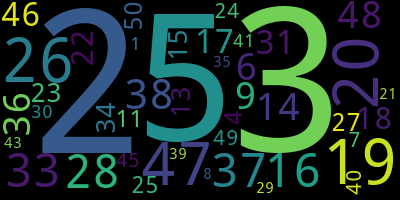

In [17]:
wordcloud.WordCloud().fit_words(compute_freqs(queries, labels)).to_image()

In [18]:
similar_queries = queries[labels == 0][['query_id', 'description']]
similar_queries = similar_queries.rename(columns={'query_id':'qid', 'description':'query'})
similar_queries

,qid,query
5,6,type ii rapid prompt test testing covid19 dise...
8,9,covid19 disease affect affected canada united
35,36,protein proteins structure cryoelectron sarsco...
47,48,benefit harm risk contracting reopen lift scho...


In [19]:
tfidf = index_model(index_en_docs_abstract, model="TF_IDF")
bm25 = index_model(index_en_docs_abstract, model="BM25")
dirichlet_lm = index_model(index_en_docs_abstract, model="DirichletLM")

exp = pt.Experiment(
    [bm25],
    similar_queries,
    qrels,
    perquery=True,
    eval_metrics=[P@5, P@10, nDCG@10, RR(rel=2)],
    names=["BM25"]
)
display(exp)

,name,qid,measure,value
8,BM25,36,P@5,0.600000
9,BM25,36,P@10,0.500000
10,BM25,36,nDCG@10,0.554801
11,BM25,36,RR(rel=2),1.000000
12,BM25,48,P@5,1.000000
13,BM25,48,P@10,1.000000
14,BM25,48,nDCG@10,1.000000
15,BM25,48,RR(rel=2),1.000000
0,BM25,6,P@5,0.600000
1,BM25,6,P@10,0.300000
